# Save Wally!

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import savewally
from importlib import reload
from PIL import Image
from skimage import feature

In [2]:
df = pd.read_csv("data/Linga Holm_ORKlh_2016_3&4_20180906.csv")
df = df[df.image_file =='StitchMICE_ORKlh16_3_1104_CP_FINAL.tif']

,image_file,class,x,y,date_counted
3036,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,double,37981,17915,24/05/2018
3037,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,double,38858,17869,24/05/2018
3038,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,double,40927,53181,24/05/2018
3039,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,double,41625,48951,24/05/2018
3040,StitchMICE_ORKlh16_3_1104_CP_FINAL.tif,double,43237,40321,24/05/2018


## Append filepaths to dataframe

In [5]:
# loop over every row
k = 8  # level
filepaths = []
for i, row in df.iterrows():
    row, col = savewally.LocateTile(row.x, row.y, savewally.SizeTile)
    filepaths.append(savewally.GetFilepath(k, row, col))
df["fp"] = filepaths

In [10]:
df["class"].unique()

array(['whitecoat', 'moulted', 'dead', 'double'], dtype=object)

## Load images

array(['8/5/139.png', '8/5/138.png', '8/6/136.png', ..., '8/94/73.png',
       '8/130/136.png', '8/148/69.png'], dtype=object)

In [21]:
df.fp.unique()

array(['8/5/139.png', '8/5/138.png', '8/6/136.png', ..., '8/94/73.png',
       '8/130/136.png', '8/148/69.png'], dtype=object)

In [95]:
images = []
image_filepaths = []
for fp in df.fp.unique():  # [df["class"]=="whitecoat"]
    im = Image.open("data/Stitch_3/" + fp)
    images.append(im)
    image_filepaths.append(fp)

In [164]:
def plot_rect(img, x, y, dx, dy):
    patch, bbox = extract_patch(img, x, y, dx, dy)
    extent = bbox[0], bbox[2], bbox[1], bbox[3]
    # plot tile
    plt.imshow(np.asarray(img)[::-1,:,:])
    # plot seal loc
    plt.scatter(x, y)
    # plot patch
    plt.imshow(patch[::-1,:,:], extent=extent,  alpha=1)
    plt.imshow(np.ones(patch[::-1,:,:].shape), extent=extent,  alpha=0.3)
    plt.xlim(0,256)
    plt.ylim(0,256)

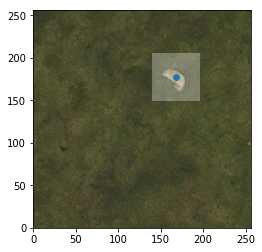

In [165]:
x, y = df[df.fp == image_filepaths[39]].x.values[0], df[df.fp == image_filepaths[39]].y.values[0]
plot_rect(images[39], x%256, y%256, 28, 28)

# Generate patches

In [114]:
def do_box(x, y, dx, dy):
    return  x - dx, y - dy, x + dx, y + dy 

def overlap(b1,b2):
    hoverlaps = (b1[0] <= b2[2]) and (b1[2] >= b2[0])
    voverlaps = (b1[3] >= b2[1]) and (b1[1] <= b2[3])
    return hoverlaps and voverlaps

def extract_patch(img, x, y, dx, dy):
    # x, X, y, Y
    # box = (centroid[0] - xbound, centroid[0] + xbound, 256 - centroid[1] - ybound, 256 - centroid[1] + ybound)
    # box = x - dx, y - dy, x + dx, y + dy
    box = do_box(x, y, dx, dy)
    # bbox = (x, x + dx, y, y + dy)
    # print(bbox)
    patch = np.asarray(img)[::-1,:,:][box[1]:box[3], box[0]:box[2]]
    return patch, box

In [66]:
dx, dy = 32, 32

In [67]:
import tqdm

In [183]:
def extract_multiple_patches(img, fp, n, plot=True):
    patches = []
    patches_boxes = []
    patches_bool = []
    patches_fp = []

    for n_patches in range(n):
        x,y = (np.random.randint(dx, 256 - dx), 
               np.random.randint(dy, 256 - dy))
        patch, patch_box = extract_patch(img, x, y, dx, dy)
              
        if plot:
            plot_rect(img, x, y, dx, dy)
            
        patches.append(patch)
        patches_boxes.append(patch_box)
        patches_fp.append(fp)
        
        seals = df[df.fp==fp]
        for i, seal in seals.iterrows():
            seal_box = do_box(seal.x%256, seal.y%256, dx, dy)
            
            
            is_seal = overlap(seal_box, patch_box)
            if plot:
                print(is_seal)
            patches_bool.append(is_seal)

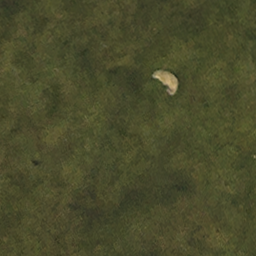

In [179]:
images[39]

True


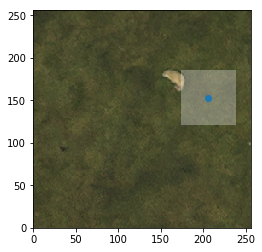

In [186]:
extract_multiple_patches(images[39], image_filepaths[39], 1)

In [230]:
patches = []
patches_boxes = []
patches_bool = []
patches_fp = []

for img, fp in zip(images, image_filepaths):
    for n_patches in range(10):
        x,y = (np.random.randint(dx, 256 - dx), 
               np.random.randint(dy, 256 - dy))
        patch, patch_box = extract_patch(img, x, y, dx, dy)
  
        
        patches.append(patch)
        patches_boxes.append(patch_box)
        
        seals = df[df.fp == fp]
        patches_fp.append(fp)
        bools = []
        for i, seal in seals.iterrows():
            seal_box = do_box(seal.x%256, seal.y%256, dx, dy)
            bools.append(overlap(seal_box, patch_box))
        
        patches_bool.append(bool(np.count_nonzero(bools)))

In [231]:
len(images)

2519

In [232]:
len(patches)

25190

In [233]:
len(patches_bool)

25190

In [225]:
np.count_nonzero(patches_bool)

7245

# greyscale and Hog

In [234]:
hogs = []
for patch in patches:
    greyscale = savewally.RGB2Lum(patch)
    hog_vec = feature.hog(greyscale, visualize=False)
    hogs.append(hog_vec)

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [204]:
len(hogs)

25190

In [235]:
X = np.array(hogs)
y = np.array(patches_bool)[:,np.newaxis]

In [236]:
X.shape

(25190, 2916)

In [237]:
y.shape

(25190, 1)

In [241]:
from sklearn.model_selection import train_test_split

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [248]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [249]:
score = clf.score(X_val, y_val)

In [250]:
score

0.7465263993648273

In [251]:
from sklearn.metrics import classification_report
print(classification_report(y_val, clf.predict(X_val), digits=3))

              precision    recall  f1-score   support

       False      0.746     0.995     0.852      3707
        True      0.787     0.056     0.104      1331

   micro avg      0.747     0.747     0.747      5038
   macro avg      0.766     0.525     0.478      5038
weighted avg      0.757     0.747     0.655      5038

